In [1]:
## Load in the data
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
import tensorflow
import keras
import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
%matplotlib inline

C:\local\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\local\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
columns=['seconds','mic (trachea)','abdominal movement (stretch sensor)','thorax movement (stretch sensor)']
data_test=['seconds','thorax movement (stretch sensor)','abdominal movement (stretch sensor)','mic (right of trachea)','mic 2 (left of trachea)','mic (trachea)',]

In [3]:
data = np.load('overnight_all_compressed.npz')


In [4]:
final_array=np.array([])

a = data['arr_0']
b = data['arr_1']
c = data['arr_2']
d= c[:,(0,5,2,1)]

#change the below numpy array to stack required files and perform modelling on
final_array=np.vstack([b,d])

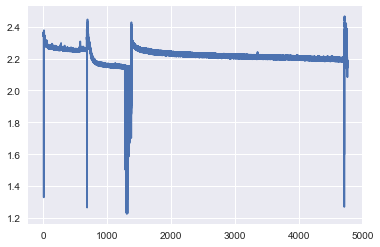

In [5]:
plt.plot(b[::,0],b[::,2])

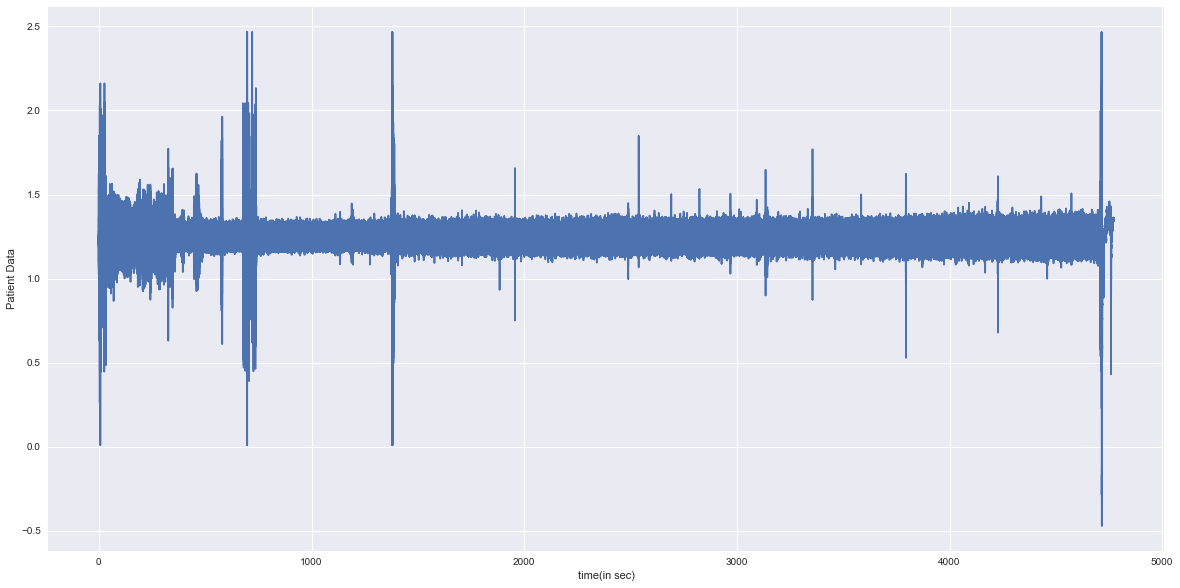

In [6]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(b[:,0],b[:,1],label='mic (trachea)')
#ax.plot(overnight_file1['seconds'],overnight_file1['abdominal movement (stretch sensor)'],label='abdominal movement (stretch sensor)')
#ax.plot(overnight_file1['seconds'],overnight_file1['thorax movement (stretch sensor)'],label='thorax movement (stretch sensor)')
#ax.set_xlim(0,100,1000)
ax.set_ylabel('Patient Data')
ax.set_xlabel('time(in sec)')

In [7]:
#create a dataframe of required file to check stats
df = pd.DataFrame(final_array,columns=columns)
#change below to see stats tests for different files
df = pd.DataFrame(d,columns=columns)


http://barnesanalytics.com/analyzing-multivariate-time-series-using-arimax-in-python-with-statsmodels 


http://barnesanalytics.com/basics-of-arima-models-with-statsmodels-in-python

In [8]:
#to see the ADFuller test results - to verify the stationarity of data
print(sm.tsa.stattools.adfuller(df['mic (trachea)'],autolag=None,maxlag=0))
print(sm.tsa.stattools.adfuller(df['abdominal movement (stretch sensor)'],autolag=None,maxlag=0))
print(sm.tsa.stattools.adfuller(df['thorax movement (stretch sensor)'],autolag=None,maxlag=0))


(-2872.4354894122707, 0.0, 0, 15437777, {'1%': -3.43035042359085, '5%': -2.8615401872225696, '10%': -2.566770099651665})
(-55.95146404576405, 0.0, 0, 15437777, {'1%': -3.43035042359085, '5%': -2.8615401872225696, '10%': -2.566770099651665})
(-42.30720663353923, 0.0, 0, 15437777, {'1%': -3.43035042359085, '5%': -2.8615401872225696, '10%': -2.566770099651665})


Get the timestamp given the no.of milliseconds

In [9]:
def get_time(ml):
    milliseconds = (str)(ml % 1000)
    seconds = (int) ((ml / 1000) % 60)
    minutes = (int) ((ml / (1000*60)) % 60)
    hours   = (int) ((ml / (1000*60*60)) % 24)
    hours = "0" + (str)(hours) if(hours < 10)  else (str)(hours)
    minutes = "0" + (str)(minutes) if(minutes < 10)  else (str)(minutes)
    seconds ="0" + (str)(seconds) if (seconds < 10)  else (str)(seconds)
    
    return (' '+ hours + ":" + minutes + ":" + seconds + "." + milliseconds+"000")

#print('*********'+str(4*60*60*1000+17*60*1000+17*1000+778))
#print('**************'+ str(milliseconds))
#index=pd.date_range(start=('2018-05-05 01:00:00.000'), end=get_time(df.shape[0]), freq='1MS').tz_localize('UTC')
#index = df.between_time(start_time='2018-05-05 01:00:00.000', end_time=get_time(df.shape[0]),include_start=True,include_end=True)

In [10]:
start = '2018-05-05 00:00:00.000'
#end = '2018-05-05 00:00:00.100'
end_date = start.split(' ')[0]
end =end_date+get_time(df.shape[0]-1)
print(end)
times = pd.DatetimeIndex(freq='1ms', start=start, end=end)
df['index']=times
df =df.set_index('index')

2018-05-05 04:17:17.777000


In [11]:
df['const']=1 
model1=sm.OLS(endog=df['mic (trachea)'],exog=df[['abdominal movement (stretch sensor)','const']])
results1=model1.fit()
print(results1.summary())


                            OLS Regression Results                            
Dep. Variable:          mic (trachea)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     65.63
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           5.45e-16
Time:                        18:12:23   Log-Likelihood:             2.7373e+07
No. Observations:            15437778   AIC:                        -5.475e+07
Df Residuals:                15437776   BIC:                        -5.475e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
ab

In [12]:
df['diffS']=df['mic (trachea)'].diff() 
df['diffM']=df['abdominal movement (stretch sensor)'].diff() 
model2=sm.OLS(endog=df['diffS'].dropna(),exog=df[['diffM','const']].dropna()) 
results2=model1.fit() 
print(results2.summary())


                            OLS Regression Results                            
Dep. Variable:          mic (trachea)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     65.63
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           5.45e-16
Time:                        18:12:28   Log-Likelihood:             2.7373e+07
No. Observations:            15437778   AIC:                        -5.475e+07
Df Residuals:                15437776   BIC:                        -5.475e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
ab

In [13]:
print(sm.tsa.stattools.grangercausalitytests(df[['mic (trachea)','abdominal movement (stretch sensor)']].dropna(),1))
print(sm.tsa.stattools.grangercausalitytests(df[['abdominal movement (stretch sensor)','mic (trachea)']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=33.1971 , p=0.0000  , df_denom=15437774, df_num=1
ssr based chi2 test:   chi2=33.1971 , p=0.0000  , df=1
likelihood ratio test: chi2=33.1971 , p=0.0000  , df=1
parameter F test:         F=33.1971 , p=0.0000  , df_denom=15437774, df_num=1
{1: ({'ssr_ftest': (33.19710924928564, 8.327581172989513e-09, 15437774.0, 1), 'ssr_chi2test': (33.19711570043123, 8.32739608019971e-09, 1), 'lrtest': (33.1970901042223, 8.327505696797156e-09, 1), 'params_ftest': (33.19711928837038, 8.327538174348094e-09, 15437774.0, 1)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002068ED9F8D0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000206E1603860>, array([[0., 1., 0.]])])}

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.8261 , p=0.0000  , df_denom=15437774, df_num=1
ssr based chi2 test:   chi2=17.8261 , p=0.0000  , df=1
likelihood ratio test: ch

In [14]:
df['lag']=df['diffM'].shift()
#df.dropna(inplace=True)
model3=sm.tsa.ARIMA(endog=df['mic (trachea)'],exog=df['abdominal movement (stretch sensor)'],order=[1,1,0])
results3=model3.fit()
print(results3.summary())

C:\local\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\local\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                             ARIMA Model Results                              
Dep. Variable:        D.mic (trachea)   No. Observations:             15437777
Model:                 ARIMA(1, 1, 0)   Log Likelihood            26730626.081
Method:                       css-mle   S.D. of innovations              0.043
Date:                Tue, 14 Aug 2018   AIC                      -53461244.161
Time:                        18:15:52   BIC                      -53461185.952
Sample:                    05-05-2018   HQIC                     -53461229.709
                         - 05-05-2018                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                2.077e-05      0.000      0.124      0.901      -0.000       0.000
abdominal movement (stretch sensor) -1.872e-05      0.00

In [15]:
y_pred=model3.predict(b[::,1])

C:\local\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


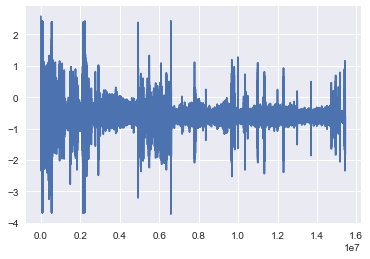

In [16]:
plt.plot(y_pred)


In [ ]:
fig = plt.figure(figsize=(20,10))
#for ix,items in zip([1,2],x):
ax = fig.add_subplot(2,1,1)
ax.set_title('Time vs Patient Data')
ax.set_xlabel('Time(in sec)')
ax.set_ylabel('Patient Data')
#ax.plot(y_pred,label='abdominal movement (stretch sensor)_pred')
ax.plot(d[0],d[2],label='abdominal movement (stretch sensor)_true')
#ax.plot(final_array[:,2],label='abdominal movement (stretch sensor)_original')




ax.legend()


In [ ]:
print(Xtrain.shape)
print(ytrain.shape)

#Xtrain=Xtrain.reshape(-1,1)
#ytrain=ytrain.reshape(-1,1)
Xtest=Xtest.reshape(-1,1)

In [ ]:
X_train = df[:,1]
Y_train = final_array[:,2]
l= len(X_train)
Xtrain = X_train[:round(l*0.7)]
Xtest = X_train[round(l*0.7)+1:]
ytrain = Y_train[:round(l*0.7)]
ytest = Y_train[round(l*0.7)+1:]

In [ ]:
window_size = 1000
leftover = len(Xtrain)%window_size

X_reshaped_train=(Xtrain[:-leftover]).reshape(-1,window_size,1)
print(X_reshaped_train.shape)

y_reshaped_train=(ytrain[:-leftover]).reshape(-1,window_size,1)

leftover_test = len(Xtest)%window_size

X_reshaped_test=(Xtest[:-leftover_test]).reshape(-1,window_size,1)
y_reshaped_test=(ytest[:-leftover_test]).reshape(-1,window_size,1)


In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression()
regr.fit(Xtrain,ytrain)
y_pred = regr.predict(Xtest)

In [ ]:
plt.plot(ytest,  color='black')
plt.plot(y_pred, color='blue')


In [ ]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(4,  kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)


# Xtrain=(Xtrain).reshape(len(Xtrain),1,1)

# ytrain=ytrain.reshape(len(ytrain),1,1)

# Xtest=Xtest.reshape(len(Xtest),1,1)

# ytest=ytest.reshape(len(ytest),1,1)

validationData=(Xtest,ytest)
'''
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)'''
print(Xtrain.shape)

model=baseline_model()
history = model.fit(X_reshaped_train,y_reshaped_train,
                    validation_data=(X_reshaped_test, y_reshaped_test),
                    epochs=3,batch_size=50,
                    callbacks=[early_stopping])

In [ ]:
y_pred=model.predict(X_reshaped_train)
y_pred_unravel=y_pred.reshape(-1,1)
print(y_pred_unravel.shape)

In [ ]:
y_pred=model.predict(X_reshaped_train)
y_pred.reshape(-1,1)
print(y_pred.shape)
y_pred= y_pred.reshape(-1,1)
print(y_pred)
fig = plt.figure(figsize=(20,10))
#for ix,items in zip([1,2],x):
ax = fig.add_subplot(2,1,1)
ax.set_title('Time vs Patient Data')
ax.set_xlabel('Time(in sec)')
ax.set_ylabel('Patient Data')
ax.plot(y_pred,label='abdominal movement (stretch sensor)_pred')
ax.plot(y_reshaped_train.reshape(-1,1),label='abdominal movement (stretch sensor)_true')
#ax.plot(final_array[:,2],label='abdominal movement (stretch sensor)_original')




ax.legend()


In [ ]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

In [ ]:
kfold = KFold(n_splits=2, random_state=seed)
results = cross_val_score(estimator, X_train, Y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
#http://barnesanalytics.com/analyzing-multivariate-time-series-using-arimax-in-python-with-statsmodels import statsmodels.api as sm print(sm.tsa.stattools.adfuller(df['Marketing'])) print(sm.tsa.stattools.adfuller(df['Sales']))
df['const']=1 model1=sm.OLS(endog=df['Sales'],exog=df['Marketing','const']) results1=model1.fit() print(results1.summary())
df['diffS']=df['Sales'].diff() df['diffM']=df['Marketing'].diff() model2=sm.OLS(endog=df['diffS'].dropna(),exog=df'diffM','const'.dropna()) results2=model1.fit() print(results2.summary())
#http://barnesanalytics.com/basics-of-arima-models-with-statsmodels-in-python